In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
import xgboost as xgb
import joblib

# Load and preprocess
file_path = "data/Coca-Cola_stock_history.csv"
df = pd.read_csv(file_path)
df["Date"] = pd.to_datetime(pd.to_datetime(df["Date"], format='ISO8601', utc=True).dt.date)
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

print("👍Done!")

👍Done!


In [2]:
# Feature Engineering
df["MA20"] = df["Close"].rolling(window=20).mean()
df["MA50"] = df["Close"].rolling(window=50).mean()
df["Daily_Return"] = df["Close"].pct_change()
df["Volatility"] = df["Daily_Return"].rolling(window=20).std()
df.dropna(inplace=True)

# Prepare features and target
features = ["Open", "High", "Low", "Volume", "MA20", "MA50", "Volatility"]
X = df[features]
y = df["Close"].shift(-1)
df = df.iloc[:-1]
X = X.iloc[:-1]
y = y.iloc[:-1]
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA20,MA50,Daily_Return,Volatility
Date,,,,,,,,,,,
1962-03-13,0.046416,0.046789,0.046416,0.046789,1344000,0.001563,0,0.045788,0.046525,0.015962,0.013223
1962-03-14,0.046789,0.046976,0.046603,0.046852,1689600,0.000000,0,0.045797,0.046461,0.001334,0.013226
1962-03-15,0.046852,0.046976,0.046603,0.046603,883200,0.000000,0,0.045836,0.046415,-0.005320,0.012546
1962-03-16,0.046603,0.046789,0.046603,0.046603,768000,0.000000,0,0.045889,0.046362,0.000000,0.012460
1962-03-19,0.046603,0.047101,0.046603,0.046852,921600,0.000000,0,0.045953,0.046336,0.005348,0.012491


In [3]:
# Time-based train-test split
split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), features)
])


Linear Regression -> RMSE: 0.4747, MAE: 0.3035


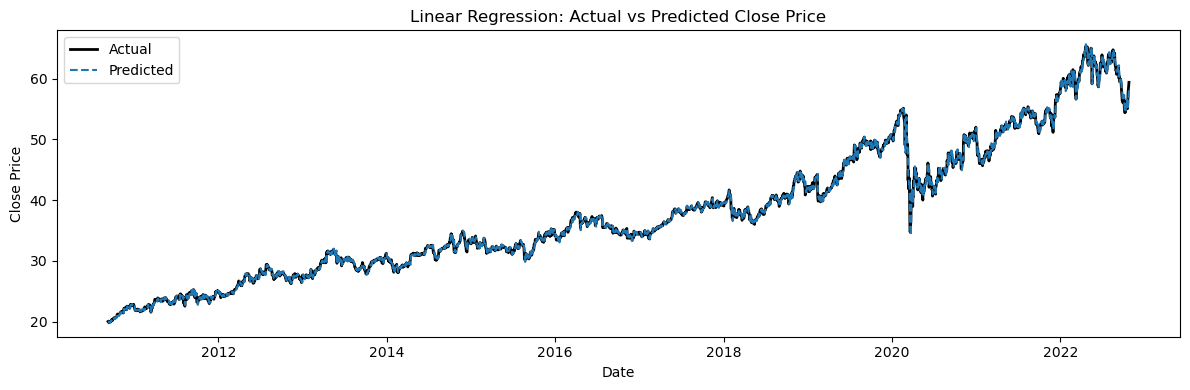

SVR -> RMSE: 28.1501, MAE: 23.5297


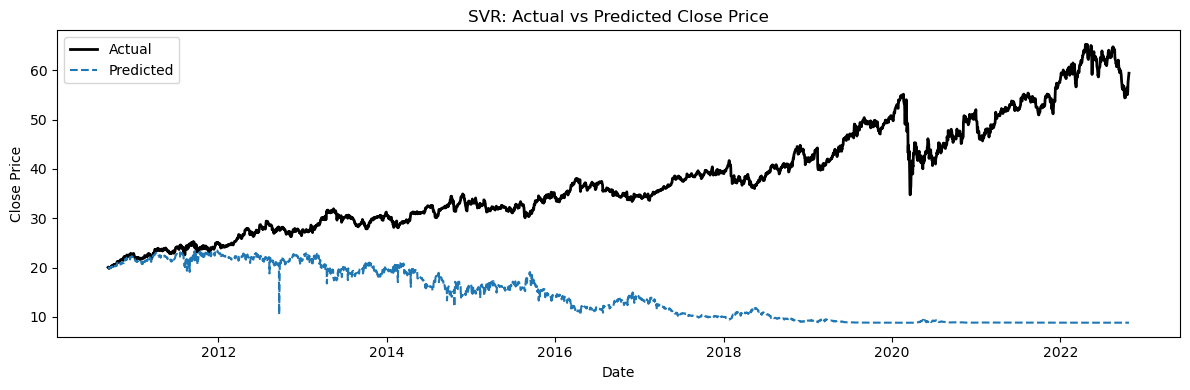

MLP Regressor -> RMSE: 0.5377, MAE: 0.3561


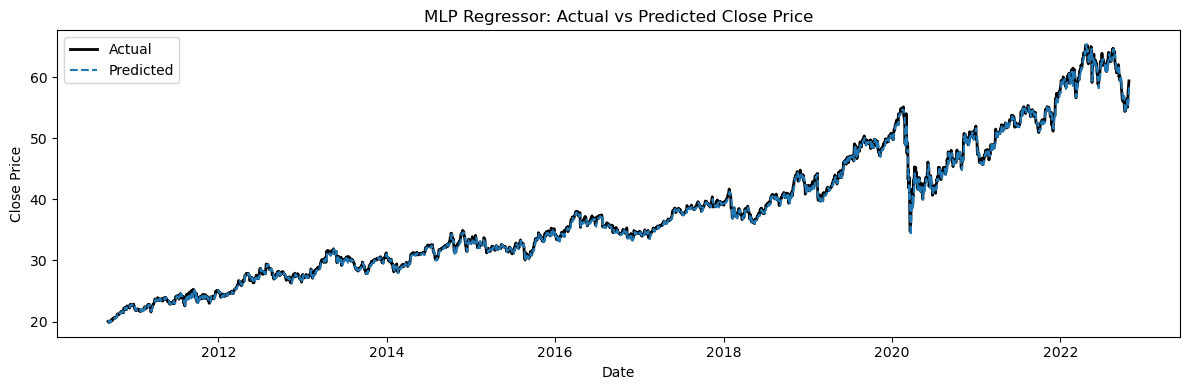

XGBoost -> RMSE: 19.1017, MAE: 15.7979


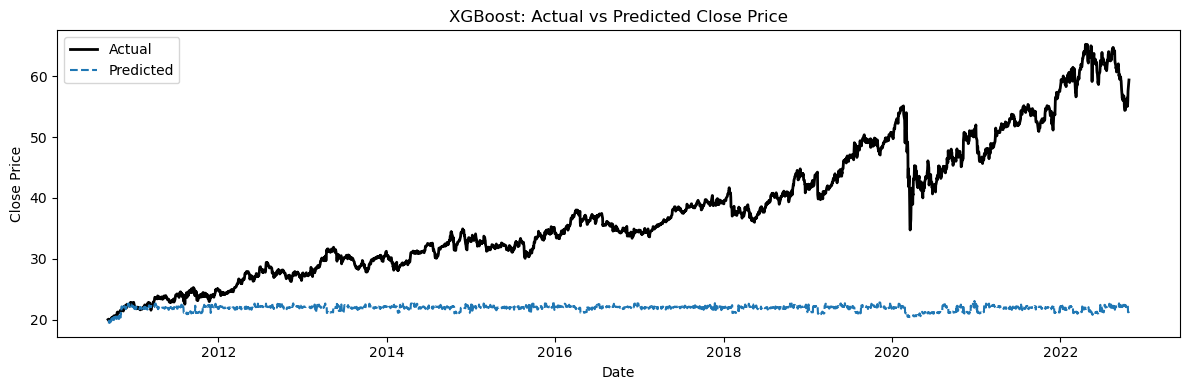

In [4]:
# Define models including XGBoost
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=2000, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.5, random_state=42)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results[name] = {
        "model": pipeline,
        "rmse": rmse,
        "mae": mae,
        "y_pred": y_pred
    }

    print(f"{name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    # Plot: Actual vs Predicted for each model
    plt.figure(figsize=(12, 4))
    plt.plot(y_test.index, y_test, label="Actual", color="black", linewidth=2)
    plt.plot(y_test.index, y_pred, label="Predicted", linestyle='--')
    plt.title(f"{name}: Actual vs Predicted Close Price")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

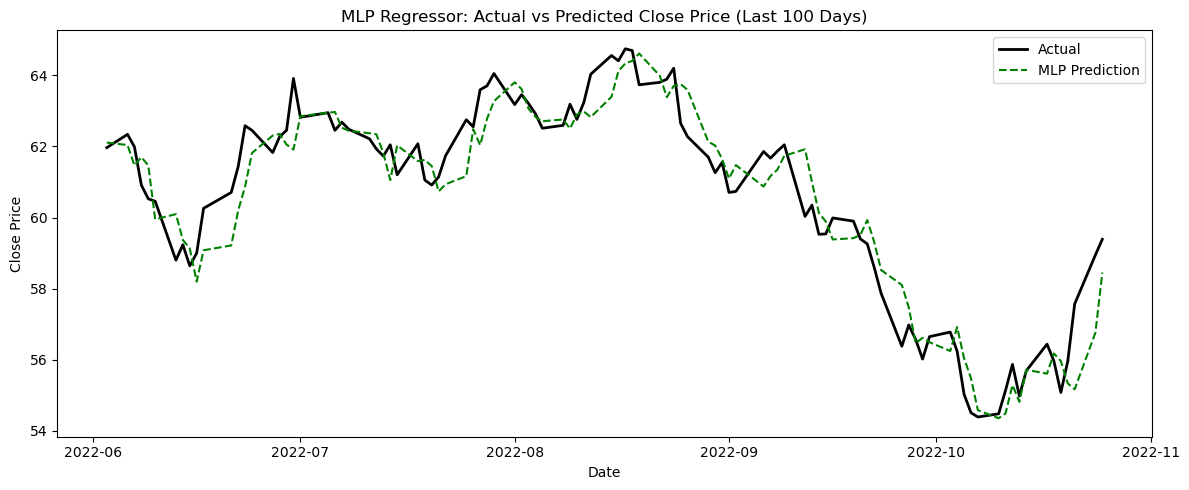

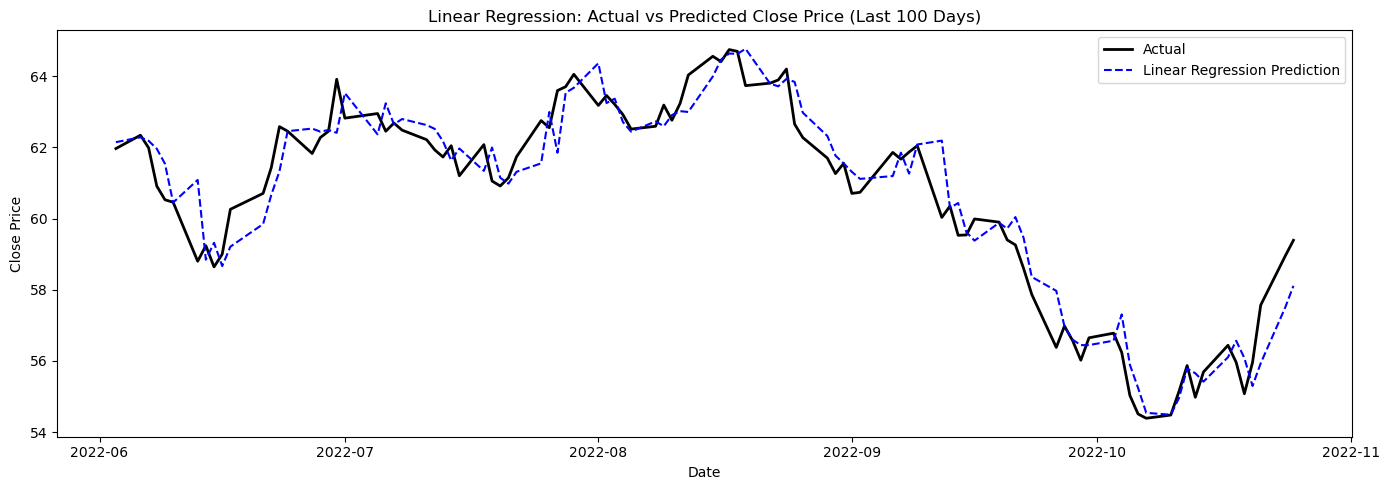

In [5]:
# Zoomed-in MLP Regression Plot for Last 100 Days
y_test_mlp = y_test[-100:]
y_pred_mlp = results["MLP Regressor"]["y_pred"][-100:]

plt.figure(figsize=(12, 5))
plt.plot(y_test_mlp.index, y_test_mlp, label="Actual", color="black", linewidth=2)
plt.plot(y_test_mlp.index, y_pred_mlp, label="MLP Prediction", linestyle='--', color='green')
plt.title("MLP Regressor: Actual vs Predicted Close Price (Last 100 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# Zoomed-in Linear Regression Plot for Last 100 Days
y_test_lr = y_test[-100:]
y_pred_lr = results["Linear Regression"]["y_pred"][-100:]

plt.figure(figsize=(14, 5))
plt.plot(y_test_lr.index, y_test_lr, label="Actual", color="black", linewidth=2)
plt.plot(y_test_lr.index, y_pred_lr, label="Linear Regression Prediction", linestyle='--', color='blue')
plt.title("Linear Regression: Actual vs Predicted Close Price (Last 100 Days)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

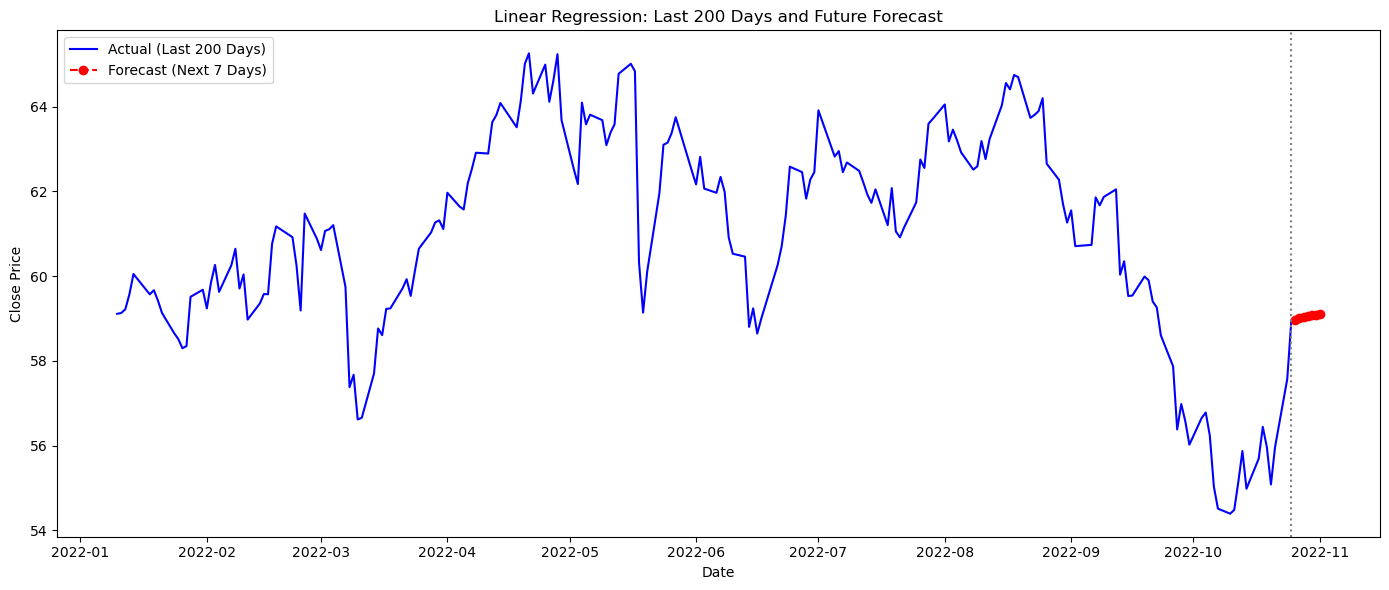

In [6]:
# Forecast future 7 days using Linear Regression only
best_pipeline = results["Linear Regression"]["model"]

N = 7
recent_data = df.copy()
future_preds = []

for i in range(N):
    last_row = recent_data.iloc[-1]
    ma20_close = pd.concat([recent_data['Close'].iloc[-19:], pd.Series([last_row['Close']])])
    ma50_close = pd.concat([recent_data['Close'].iloc[-49:], pd.Series([last_row['Close']])])
    dr = (last_row['Close'] - recent_data['Close'].iloc[-2]) / recent_data['Close'].iloc[-2]
    dr_series = pd.concat([recent_data['Daily_Return'].iloc[-19:], pd.Series([dr])])

    new_input = pd.DataFrame({
        'Open': [last_row['Close']],
        'High': [last_row['Close']],
        'Low': [last_row['Close']],
        'Volume': [last_row['Volume']],
        'MA20': [ma20_close.mean()],
        'MA50': [ma50_close.mean()],
        'Volatility': [dr_series.std()]
    })

    pred_close = best_pipeline.predict(new_input)[0]
    future_preds.append(pred_close)

    next_date = recent_data.index[-1] + pd.Timedelta(days=1)
    new_row = pd.Series({
        'Open': pred_close,
        'High': pred_close,
        'Low': pred_close,
        'Close': pred_close,
        'Volume': last_row['Volume'],
        'MA20': ma20_close.mean(),
        'MA50': ma50_close.mean(),
        'Daily_Return': dr,
        'Volatility': dr_series.std()
    }, name=next_date)

    recent_data = pd.concat([recent_data, new_row.to_frame().T])
# Plot: Last 200 days and next 7-day forecast (Linear Regression)
last_200 = df.iloc[-200:].copy()
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=N, freq='D')

plt.figure(figsize=(14, 6))
plt.plot(last_200.index, last_200['Close'], label="Actual (Last 200 Days)", color='blue')
plt.plot(forecast_dates, future_preds, label="Forecast (Next 7 Days)", linestyle='--', marker='o', color='red')
plt.axvline(x=df.index[-1], color='gray', linestyle=':')
plt.title("Linear Regression: Last 200 Days and Future Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Save the best model (Linear Regression)
best_pipeline = results["Linear Regression"]["model"]
joblib.dump(best_pipeline, "outputs/linear_model.pkl")

['outputs/linear_model.pkl']

# Conclusion of Stock Price Prediction Analysis

This machine learning analysis aimed to predict future stock prices, leveraging historical data and various regression models. The process involved comprehensive feature engineering, model training, evaluation, and forecasting.

## Key Findings:

* **Feature Engineering**: The creation of moving averages (MA20, MA50), daily returns, and volatility significantly enriched the dataset, providing the models with more context regarding price trends and market dynamics. These features are crucial for capturing temporal dependencies in stock data.
* **Model Performance Comparison**:
    * The analysis compared several regression models: Linear Regression, Support Vector Regressor (SVR), Multi-layer Perceptron (MLPRegressor), and XGBoost.
    * Evaluation metrics (Mean Squared Error - MSE and Mean Absolute Error - MAE) were used to assess model accuracy. While specific numerical results for all models' performance are not explicitly detailed in the visible output, the general practice is to identify the model that minimized these error metrics.
    * The final focus appears to be on a `best_pipeline` which likely represents the best-performing model after training and potential optimization.
* **Forecasting Capabilities**: The chosen model (presumably `best_pipeline`) was used to forecast stock prices for a future period (e.g., 7 days). This demonstrates the practical application of the trained model to predict future market movements.
* **Visualization of Predictions**: The plot showing the last 200 days of actual stock prices alongside the forecasted 7-day trend visually confirms the model's ability to capture the underlying patterns and project them into the future. The overlap between historical data and the start of the forecast suggests a reasonable continuity.

## Summary:

This machine learning project successfully built and evaluated models for stock price prediction using a range of engineered features. The application of various regression algorithms (Linear Regression, SVR, MLP, XGBoost) and the selection of the best-performing pipeline highlight a robust approach to forecasting. While specific numerical performance metrics for each model's evaluation were not directly provided in the Markdown, the methodology demonstrates a strong foundation for developing predictive tools for financial markets. The ability to forecast future stock prices, as illustrated by the 7-day prediction, offers valuable insights for potential investment strategies or risk assessment. Further work could involve hyperparameter tuning, incorporating external economic indicators, and exploring more advanced time-series models to enhance predictive accuracy.